## Exploratory Data Analysis of Canadian Bill Data (1994 - 2022)

In [49]:
# Import Python libraries
import pandas as pd
import numpy as np
import plotly.express as px

In [50]:
# Read aggregated datasets
data = pd.read_csv('../data/cleaned/bill_data.csv')
parliaments = pd.read_csv('../data/cleaned/parliament_data.csv')

# Display all columns
with pd.option_context('display.max_columns', None): 
    display(data.head(3))

,Id,SponsorName,SponsorTitle,Constituency,Political Affiliation,Code,Title,LatestStageName,ParliamentNumber,SessionNumber,BillType,ReceivedRoyalAssent,Ongoing,ReadingsPassed,BillOrigin,FirstStageDate,LastStageDate,TimeAlive
0,44-1/S-1,Yuen Pau Woo,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,44,1,Senate Public Bill,False,True,1,IsSenateBill,2021-11-22,2021-11-22,0 days
1,43-2/S-1,Marc Gold,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,2,Senate Public Bill,False,False,1,IsSenateBill,2020-09-22,2020-09-22,0 days
2,43-1/S-1,Joseph Day,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,1,Senate Public Bill,False,False,1,IsSenateBill,2019-12-04,2019-12-04,0 days


Visualization Ideas:
- Number of bills in each parliament (do parliaments have consistent length?)
- Number and percentage of bills by type
- Number of bills that made it to each stage (bar chart)
- Mean, median, and outliers of the time spent debating (amongst bills that received royal assent)
- Number of bills sponsored by political affiliation (take a subset of years as well, compare Harper and Trudeau eras)
- Group the bills by title if possible

Out of Curiosity:
- Which person sponsored the greatest number of bills, also sort by role (Senator, MP, other?)
- Which constituency sponsored the greatest number of bills

### 1-1: Bills by Parliament Number (Data Collection)

In [51]:
# Number of bills in each parliament
by_parl = data[[
    'ParliamentNumber',
    'SessionNumber',
    'ReceivedRoyalAssent', 
    'ReadingsPassed'
]].groupby([
    'ParliamentNumber',
    'SessionNumber'
])

by_parl = pd.concat([by_parl.sum(), by_parl.size()], axis = 1)

by_parl.rename(columns = {
    'ReceivedRoyalAssent': 'BillsPassed',
    'ReadingsPassed': 'TotalReadingsPassed',
    0: 'UniqueBills'
}, inplace = True)

display(by_parl.head(4))

BillsPassed  TotalReadingsPassed  UniqueBills
ParliamentNumber SessionNumber                                               
35               1                      101                  845          300
                 2                       69                  755          358
36               1                       86                  907          438
                 2                       38                  625          390

In [52]:
# Merging by_parliament with session data
by_parl = pd.merge(by_parl.reset_index(), parliaments, on = ['ParliamentNumber', 'SessionNumber'], how = 'left')

In [53]:
# Change columns to datetime format
by_parl['StartDate'] = pd.to_datetime(by_parl['StartDate'])
by_parl['EndDate'] = pd.to_datetime(by_parl['EndDate'])
by_parl['Duration'] = pd.to_timedelta(by_parl['Duration'])

# Create readings per day and bills per day columns
by_parl['ReadingsPerDay'] = by_parl['TotalReadingsPassed'] / by_parl['Duration'].dt.days
by_parl['BillsPerDay'] = by_parl['BillsPassed'] / by_parl['Duration'].dt.days

In [54]:
display(by_parl.head(3))

,ParliamentNumber,SessionNumber,BillsPassed,TotalReadingsPassed,UniqueBills,Party,PrimeMinister,Minority,StartDate,EndDate,Duration,SenateSittings,HouseSittings,ReadingsPerDay,BillsPerDay
0,35,1,101,845,300,Liberal Party,Jean Chrétien,False,1994-01-17,1996-02-02,746 days,133.0,278,1.132708,0.135389
1,35,2,69,755,358,Liberal Party,Jean Chrétien,False,1996-02-27,1997-04-27,425 days,96.0,164,1.776471,0.162353
2,36,1,86,907,438,Liberal Party,Jean Chrétien,False,1997-09-22,1999-09-18,726 days,158.0,243,1.249311,0.118457


### 1-2: Bills by Parliament (Plotting)

In [71]:
import warnings
warnings.filterwarnings("ignore")

# Removing sessions lasting less than 150 days due to the unstable nature of these parliaments

parl_plot = by_parl.loc[by_parl['Duration'].dt.days > 150, :]

# Create new column that aggregates party and minority status

parl_plot['Party'] = parl_plot['Party'].apply(lambda x: x.split(' ', 1)[0])
parl_plot['Minority'] = parl_plot['Minority'].apply(lambda x: 'Minority' if x == True else 'Majority')
parl_plot['Government'] = parl_plot['Party'] + ' ' + parl_plot['Minority']

# Create middle date column

parl_plot['StartYear'] = pd.DatetimeIndex(parl_plot['StartDate']).year.astype(str)
parl_plot = parl_plot.reset_index()

display(parl_plot.head(3))

,index,ParliamentNumber,SessionNumber,BillsPassed,TotalReadingsPassed,UniqueBills,Party,PrimeMinister,Minority,StartDate,EndDate,Duration,SenateSittings,HouseSittings,ReadingsPerDay,BillsPerDay,Government,StartYear
0,0,35,1,101,845,300,Liberal,Jean Chrétien,Majority,1994-01-17,1996-02-02,746 days,133.0,278,1.132708,0.135389,Liberal Majority,1994
1,1,35,2,69,755,358,Liberal,Jean Chrétien,Majority,1996-02-27,1997-04-27,425 days,96.0,164,1.776471,0.162353,Liberal Majority,1996
2,2,36,1,86,907,438,Liberal,Jean Chrétien,Majority,1997-09-22,1999-09-18,726 days,158.0,243,1.249311,0.118457,Liberal Majority,1997


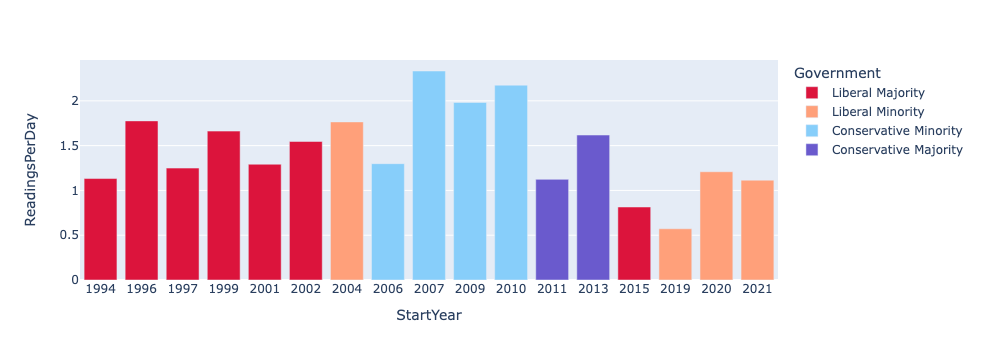

In [92]:
color_map =  { 
    "Liberal Majority": "crimson", 
    "Liberal Minority": "lightsalmon",
    "Conservative Minority": "lightskyblue",
    "Conservative Majority": "slateblue"
}

fig = px.bar(
    parl_plot, 
    x = "StartYear", 
    y = "ReadingsPerDay", 
    color="Government",
    color_discrete_map = color_map
)

fig.update_layout(xaxis={'categoryorder':'category ascending'})

fig.show()

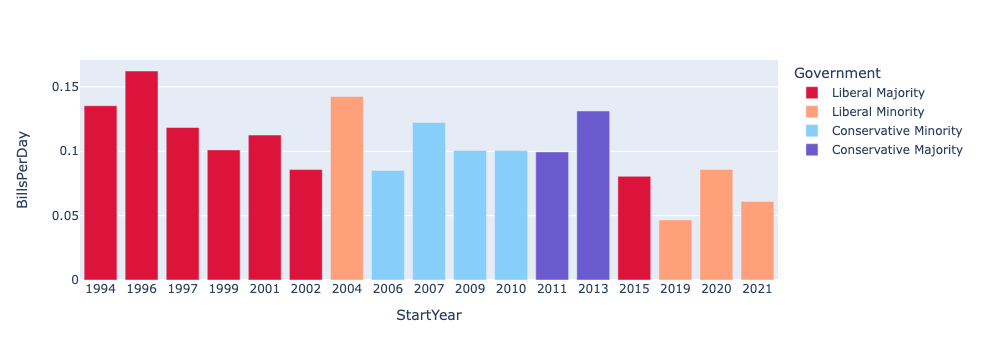

In [93]:
fig = px.bar(
    parl_plot, 
    x = "StartYear", 
    y = "BillsPerDay", 
    color="Government",
    color_discrete_map = color_map
)

fig.update_layout(xaxis={'categoryorder':'category ascending'})

fig.show()

### Part 2: Bills By Type and Origin

In [58]:
display(data.head(3))

,Id,SponsorName,SponsorTitle,Constituency,Political Affiliation,Code,Title,LatestStageName,ParliamentNumber,SessionNumber,BillType,ReceivedRoyalAssent,Ongoing,ReadingsPassed,BillOrigin,FirstStageDate,LastStageDate,TimeAlive
0,44-1/S-1,Yuen Pau Woo,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,44,1,Senate Public Bill,False,True,1,IsSenateBill,2021-11-22,2021-11-22,0 days
1,43-2/S-1,Marc Gold,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,2,Senate Public Bill,False,False,1,IsSenateBill,2020-09-22,2020-09-22,0 days
2,43-1/S-1,Joseph Day,Senator,None,NaN,S-1,An Act relating to railways,First reading in the Senate,43,1,Senate Public Bill,False,False,1,IsSenateBill,2019-12-04,2019-12-04,0 days
